In [1]:
import numpy as np
from naa import models as models
from naa import na_utils as utils
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import random

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [2]:
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS = 3
data_dir = "YOUR TINY IMAGENET DATASET HERE"
ROOT_DIR = "ROOT DIR HERE"
CHECKPOINT_DIR = ROOT_DIR + 'model_checkpoints'
FIG_DIR = ROOT_DIR + 'figs'


In [3]:
#data_dir = "tiny-imagenet-200/"
import torch.utils.data as data
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset

num_workers = {"train": 2, "val": 0, "test": 0}
# Normalized Dataset
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    )
}
# image_datasets = {
#     x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]
# }
# dataloaders = {
#     x: data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers[x],drop_last = True)
#     for x in ["train", "val"]
# }

In [4]:
torch.manual_seed(42)

# Load datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]
}

# Subset for training data
subset_indices = torch.randperm(len(image_datasets["train"]))[:2000]
train_subset = Subset(image_datasets["train"], subset_indices)

# DataLoaders
dataloaders = {
    "train": data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers["train"], drop_last=True),
    "val": data.DataLoader(image_datasets["val"], batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers["val"], drop_last=True)
}

In [72]:
p = 15
s = 10
# #samp_im = next(iter(dataloaders['train']))
# samp_im = next(iter(dataloaders['train']))
# masked_im,binary_mask = mask_random_squares(samp_im[0], p, s,device = device)


# plt.figure(figsize = (2,2))
# #imshow(samp_im[0][10])
# imshow(binary_mask[3].detach().cpu())
# plt.figure(figsize = (2,2))
# imshow(masked_im[3])
# plt.figure(figsize = (2,2))
# imshow(masked_im[4])

fraction_masked = (p*s**2)/(64**2)
print(fraction_masked)

0.3662109375


In [6]:
# masked_new = samp_im[0].to(device).view(BATCH_SIZE,-1)*binary_mask.view(BATCH_SIZE,-1)
# unflattened = masked_new.view(BATCH_SIZE,NUM_CHANNELS,IMG_HEIGHT,IMG_WIDTH).detach().cpu()
# imshow(unflattened[3])

In [7]:
# import os
# dt = 0.2
# steps = 5
# net = ContinuousRNN(input_size = int(64*64*3), dt = dt, steps = steps, device = device) # Replace with your network
# print('Finished Training')
# print('Saving Model...')
# if not os.path.exists('/om2/user/leokoz8/code/neuron_astrocyte_associative/weights'):
#     os.mkdir('./om2/user/leokoz8/code/neuron_astrocyte_associative/weights')
# torch.save(net.state_dict(), "/om2/user/leokoz8/code/neuron_astrocyte_associative/weights/tiny_imagenet_rnn.pkl")

In [8]:
# checkpoint_dir = ROOT_DIR + 'model_checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)          
# checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': net.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': running_loss,
# }, checkpoint_path)
# print(f"Checkpoint saved at epoch {epoch+1}")


In [5]:
def init_net_and_optim(CHECKPOINT_DIR,load_net,load_optim):
    # Path to the checkpoint file
    checkpoint_path = CHECKPOINT_DIR + '/epoch_1000.pth'
    
    net = models.ContinuousRNN(input_size = int(IMG_HEIGHT*IMG_WIDTH*NUM_CHANNELS), dt = dt, steps = steps, device = device, clamp = True) # Replace with your network
    
    optimizer = optim.Adam(net.parameters(), lr=5e-5, weight_decay= 1e-5)
    
    if CHECKPOINT_DIR is not None:
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        
        if load_net:
            # Restore the model's state
            net.load_state_dict(checkpoint['model_state_dict'])
        
        if load_optim:
            # Restore the optimizer's state (if necessary)
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Set the model to training mode
    net.train()

    # Get the epoch number if you want to continue from there
    #start_epoch = checkpoint['epoch'] + 1
    return net, optimizer

In [ ]:
import random


dt = 0.1
steps = 10
criterion = nn.MSELoss()
#net = models.ContinuousRNN(input_size = int(IMG_HEIGHT*IMG_WIDTH*NUM_CHANNELS), dt = dt, steps = steps, device = device, clamp = True) # Replace with your network
#optimizer = optim.Adam(net.parameters(), lr=5e-4, weight_decay= 1e-5)
net,optimizer = init_net_and_optim(CHECKPOINT_DIR = CHECKPOINT_DIR,load_net = True, load_optim = False)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5,verbose = False)

# Training loop
num_epochs = 1000  # Define the number of epochs
num_patches = 15
patch_size = 10
img_size = 64   # CIFAR10 images are 32x32
print_every = 10

checkpoint_interval = 25 # epochs
# Define the directory for saving checkpoints

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Training loop
for epoch in range(num_epochs):  # num_epochs is the number of epochs

    running_loss = 0.0
    for i, data in enumerate(dataloaders["train"], 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            # Generate patch locations for the batch
            masked_im,binary_mask = utils.mask_random_squares(inputs, num_patches, patch_size,device = device)

        # Forward + backward + optimize
        outputs = net(x0 = masked_im.view(BATCH_SIZE,-1),s0 = None, p0 = None, free_inds = binary_mask.view(BATCH_SIZE,-1))
                
        loss = criterion(outputs.view(BATCH_SIZE,NUM_CHANNELS,IMG_HEIGHT,IMG_WIDTH), inputs)
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()

        running_loss += loss.item()
        with torch.no_grad():
            if i % print_every == print_every -1 :  # print progress
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / print_every:.7f}')
                running_loss = 0.0
                
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

    #scheduler.step()


print('Finished Training')


In [6]:
checkpoint_path = CHECKPOINT_DIR + '/epoch_1000.pth'
checkpoint = torch.load(checkpoint_path)
# loading from checkpoint and testing
dt = 0.1
steps = 10 #10 was the training
num_patches = 15
patch_size = 10
img_size = 64   # CIFAR10 images are 32x32
net = models.ContinuousRNN(input_size = int(IMG_HEIGHT*IMG_WIDTH*NUM_CHANNELS), dt = dt, steps = steps, device = device, clamp = True) # Replace with your network
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
data = next(iter(dataloaders["train"]))
inputs, _ = data
inputs = inputs.to(device)



with torch.no_grad():
    # Generate patch locations for the batch
    masked_im,binary_mask = utils.mask_random_squares(inputs, num_patches, patch_size,device = device)
    #masked_im_noised = masked_im + 0.1*torch.randn(masked_im.shape,device = device)

    # Forward + backward + optimize
    outputs,hiddens = net(x0 = masked_im.view(BATCH_SIZE,-1),s0 = None, p0 = None, free_inds = binary_mask.view(BATCH_SIZE,-1))
                

In [13]:
def root_mean_squared(tensor, dim):
    """
    Calculate the root mean squared along a specified dimension of a tensor.

    Parameters:
    tensor (torch.Tensor): The input tensor.
    dim (int): The dimension along which to calculate the root mean squared.

    Returns:
    torch.Tensor: The root mean squared values along the specified dimension.
    """
    squared = torch.square(tensor)
    mean_squared = torch.mean(squared, dim=dim)
    rms = torch.sqrt(mean_squared)
    return rms


Text(0.5, 1.0, 'Distance of Neural State to Target Image')

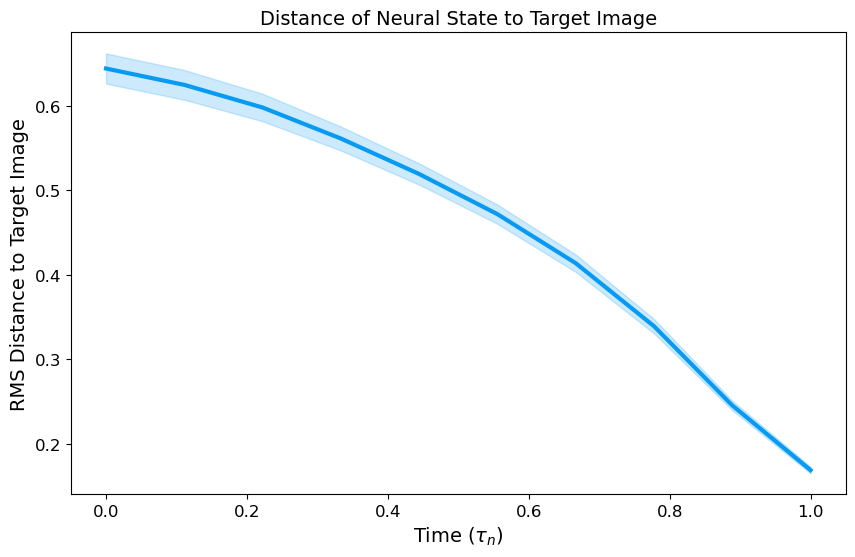

In [14]:
vel_vecs = torch.diff(hiddens,dim = 0)
vel_vec_norms = torch.norm(vel_vecs,dim = 2)
diffs_to_images = hiddens - inputs.view(BATCH_SIZE,-1)
dists_to_images = root_mean_squared(diffs_to_images,dim = 2)
#plt.plot(dists_to_images[:,:].cpu().detach());



mean = torch.mean(dists_to_images, dim=1)
std_error = torch.std(dists_to_images, dim=1) / np.sqrt(dists_to_images.size(1))

# Convert to numpy for plotting
mean = mean.detach().cpu().numpy()
std_error = std_error.detach().cpu().numpy()

# Generate time points (assuming these are linear and evenly spaced)
total_time_points = mean.shape[0]
time_points = np.linspace(0, steps*dt, total_time_points)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points, mean, label='Mean',color = '#069af3',linewidth = 3)
plt.fill_between(time_points, mean - std_error, mean + std_error, alpha=0.2, label='Standard Error',color = '#069af3')
plt.xlabel(r'Time ($\tau_n$)', fontsize=14)
plt.ylabel('RMS Distance to Target Image', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distance of Neural State to Target Image',fontsize = 14)
#plt.legend()


#plt.savefig(FIG_DIR + '/distance_state_to_image.png',dpi = 300)

In [15]:
unnormalize = transforms.Normalize(
    mean=[-0.4802/0.2302, -0.4481/0.2265, -0.3975/0.2262],
    std=[1/0.2302, 1/0.2265, 1/0.2262]
)



Original Images


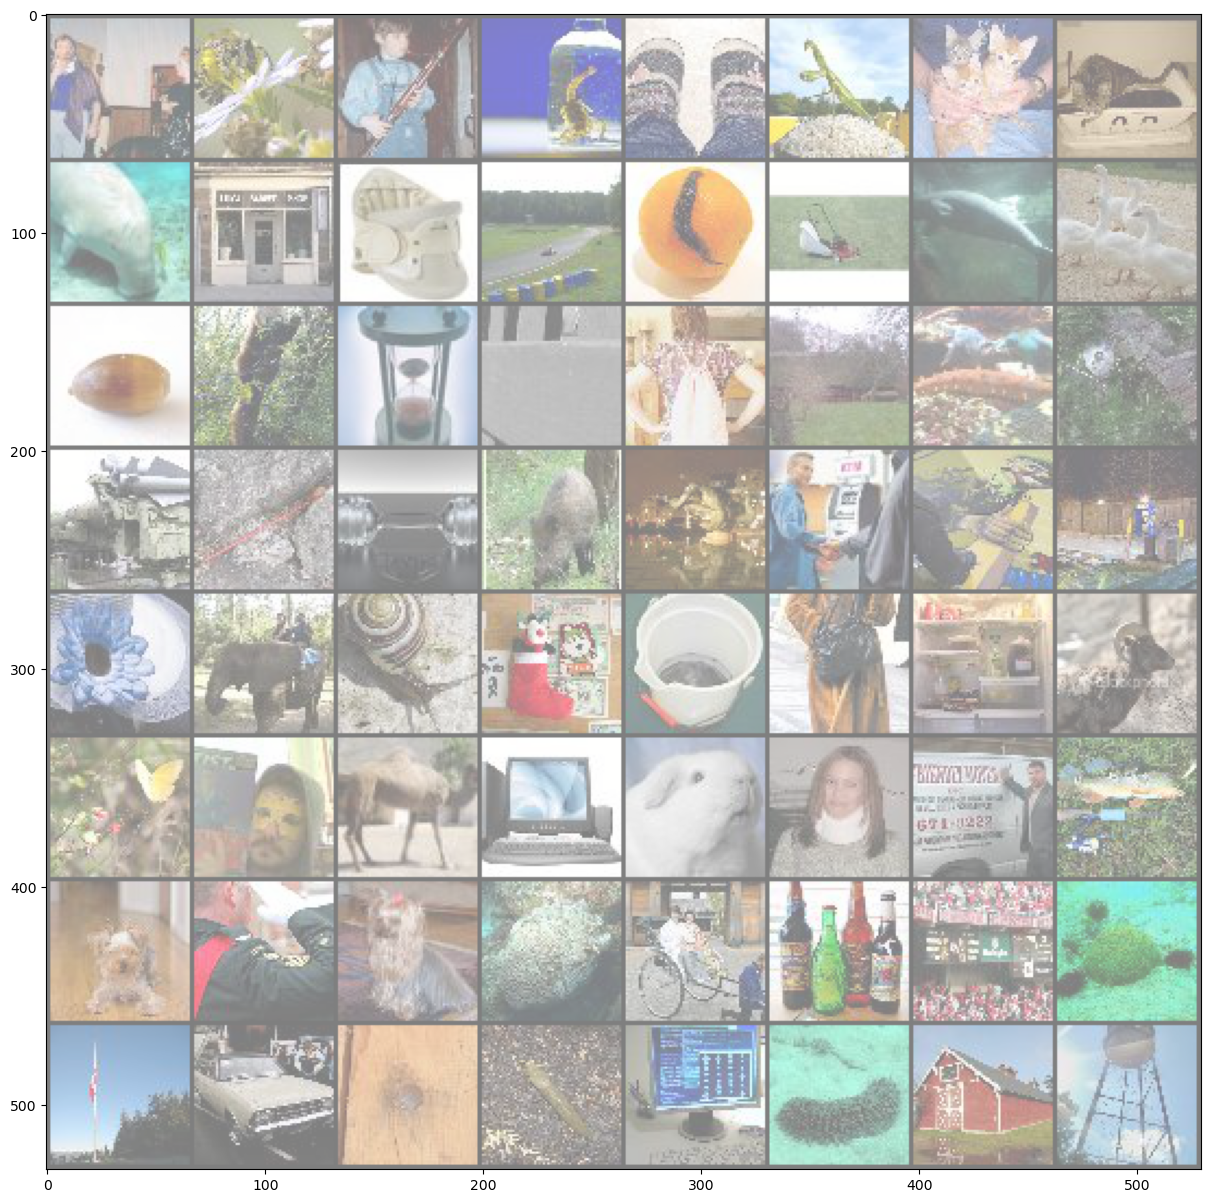

Masked Images


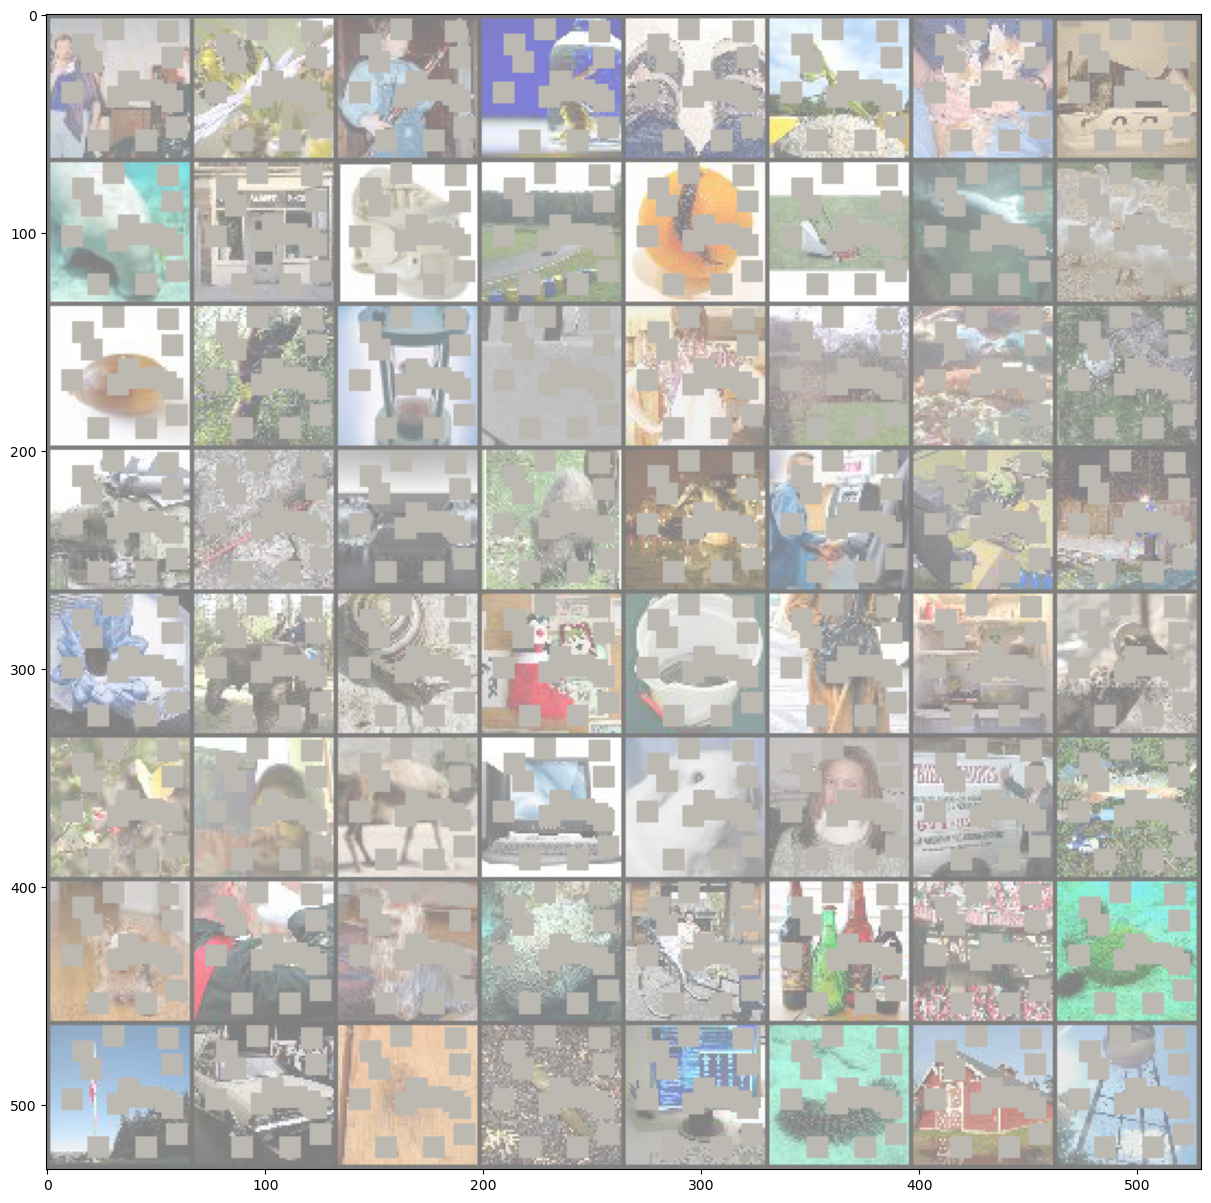

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patched Images


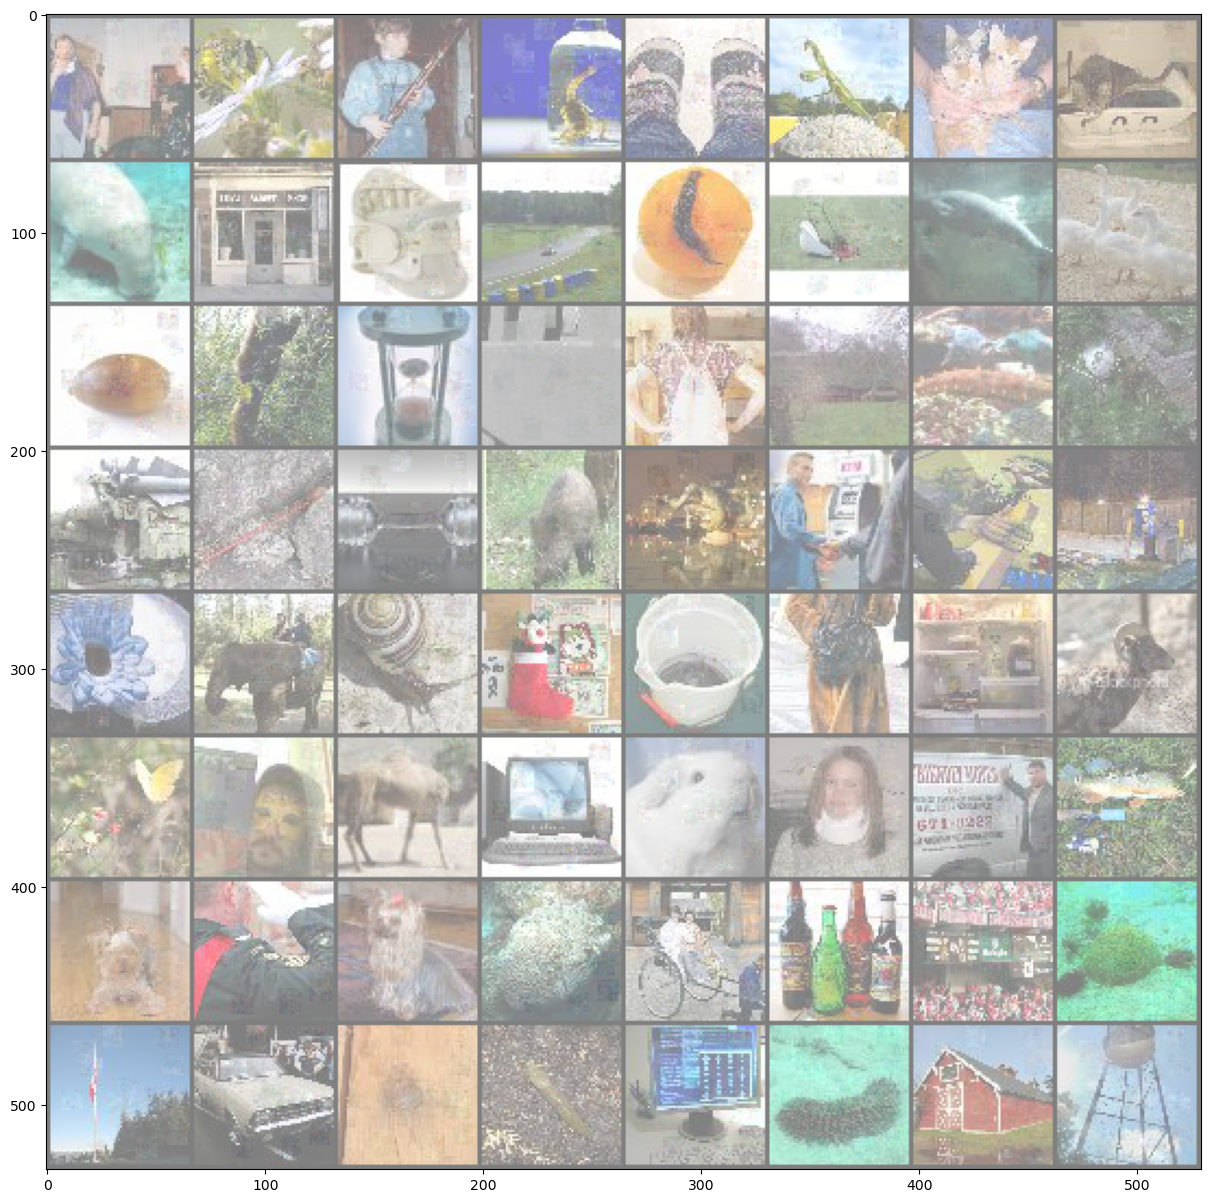

In [16]:
print('Original Images')
plt.figure(figsize=[15, 15])
imshow(torchvision.utils.make_grid(unnormalize(inputs).cpu()))

print('Masked Images')
plt.figure(figsize=[15, 15])
imshow(torchvision.utils.make_grid(unnormalize(masked_im).cpu()))

print('Patched Images')
plt.figure(figsize=[15, 15])
reconstructed = outputs.view(BATCH_SIZE,NUM_CHANNELS,IMG_HEIGHT,IMG_WIDTH)
imshow(torchvision.utils.make_grid(unnormalize(reconstructed).cpu().detach())) 

In [42]:
def pre_process_for_plot(img):
    img = unnormalize(img)
    img = img.cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    return img
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

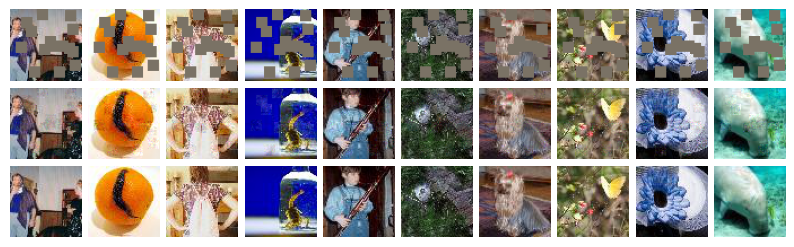

In [71]:
image_col_inds = [0,12,20,3,2,23,50,40,32,8]


# Plotting
#fig, ax = plt.subplots(3,10,figsize=(12, 5), gridspec_kw={'hspace': 0.01, 'wspace': 0.01})

 # Turn off axis
#plt.show()

# Plotting
fig, axs = plt.subplots(3, 10, figsize=(10, 3), gridspec_kw={'hspace': 0.05, 'wspace': 0.1})

def plot_im_to_ax(ax, image_number, image_set):
    image = image_set[image_number]
    image = pre_process_for_plot(image)
    ax.imshow(image)
    ax.axis('off')

for i in range(10):
    plot_im_to_ax(ax=axs[0, i], image_number=image_col_inds[i], image_set=masked_im)
    plot_im_to_ax(ax=axs[1, i], image_number=image_col_inds[i], image_set=reconstructed)
    plot_im_to_ax(ax=axs[2, i], image_number=image_col_inds[i], image_set=inputs)

# Adjust layout
# plt.tight_layout()  # Uncomment if needed, after adjusting hspace and wspace
#plt.show()

plt.savefig(FIG_DIR + '/error_corrected_images.png',dpi = 300)